In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Objective:

* Try and implement basic DL models using fastai v1 (code from 2019 course v3 DL1), Keras (what I know), Pytorch (learning)

## Project: Pet identifier

* Use Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012 which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories.

### Keras

In [57]:
import keras
from keras.models import Model
from keras.optimizers import rmsprop, adam, SGD
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras_contrib.applications import resnet
from keras.utils.vis_utils import plot_model
import tensorflow as tf

In [4]:
keras.__version__

'2.2.4'

In [5]:
tf.__version__

'1.12.0'

#### Data Setup

In [6]:
# batch size
bs = 64

In [7]:
# main path where data is
path = Path(r"C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet")
path

WindowsPath('C:/Users/Shonket Ray/.fastai/data/oxford-iiit-pet')

In [8]:
# annotations and imgs paths
path_anno = path/'annotations'
path_img = path/'images'
print(path_anno, path_img)

C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\annotations C:\Users\Shonket Ray\.fastai\data\oxford-iiit-pet\images


In [9]:
os.path.join(path_img, '*.jpg')

'C:\\Users\\Shonket Ray\\.fastai\\data\\oxford-iiit-pet\\images\\*.jpg'

In [10]:
pd.options.display.max_colwidth

50

In [11]:
# make df to use keras flow_from_dataframe
# https://medium.com/datadriveninvestor/keras-imagedatagenerator-methods-an-easy-guide-550ecd3c0a92
img_fullpaths = glob(os.path.join(path_img, '*.jpg'))
temp = [os.path.split(elem)[1].split('.')[0] for elem in img_fullpaths]
img_filenames = [os.path.split(elem)[1] for elem in img_fullpaths]
img_classes = ['_'.join(elem.split('_')[:-1]) for elem in temp]
#print(len(temp))

df = pd.DataFrame(zip(img_filenames, img_classes), columns=['filename', 'class'])
print(df.shape)

(7390, 2)


In [12]:
# view df head and counts
pd.options.display.max_colwidth = 100
df.head()

,filename,class
0,Abyssinian_1.jpg,Abyssinian
1,Abyssinian_10.jpg,Abyssinian
2,Abyssinian_100.jpg,Abyssinian
3,Abyssinian_101.jpg,Abyssinian
4,Abyssinian_102.jpg,Abyssinian


In [13]:
df.iloc[1000]

filename    Bengal_1.jpg
class             Bengal
Name: 1000, dtype: object

In [14]:
print(df['class'].nunique())
print(df['class'].value_counts().sort_index())

37
Abyssinian                    200
Bengal                        200
Birman                        200
Bombay                        200
British_Shorthair             200
Egyptian_Mau                  200
Maine_Coon                    200
Persian                       200
Ragdoll                       200
Russian_Blue                  200
Siamese                       200
Sphynx                        200
american_bulldog              200
american_pit_bull_terrier     200
basset_hound                  200
beagle                        200
boxer                         200
chihuahua                     200
english_cocker_spaniel        200
english_setter                200
german_shorthaired            200
great_pyrenees                200
havanese                      200
japanese_chin                 200
keeshond                      200
leonberger                    200
miniature_pinscher            200
newfoundland                  200
pomeranian                    200
pug        

In [32]:
# Create batch generators from df for training and validation data with real-time data aug.
datagen = ImageDataGenerator(validation_split=0.2, horizontal_flip=True)

# train_generator = train_datagen.flow_from_directory(
#         path_img,
#         target_size=(224, 224),
#         batch_size=bs, classes = list(temp))

train_generator = datagen.flow_from_dataframe(
    dataframe=df, 
    directory=path_img,
    x_col='filename',
    y_col='class', 
    subset="training",
    seed=42,
    target_size=(224, 224), 
    batch_size=bs)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df, 
    directory=path_img,
    x_col='filename',
    y_col='class', 
    subset="validation",
    seed=42,
    target_size=(224, 224), 
    batch_size=bs)

Found 5912 images belonging to 37 classes.
Found 1478 images belonging to 37 classes.


In [33]:
valid_generator.class_indices
inv_map = {v: k for k, v in valid_generator.class_indices.items()}
print(inv_map)

{0: 'Abyssinian', 1: 'american_bulldog', 2: 'american_pit_bull_terrier', 3: 'basset_hound', 4: 'beagle', 5: 'Bengal', 6: 'Birman', 7: 'Bombay', 8: 'boxer', 9: 'British_Shorthair', 10: 'chihuahua', 11: 'Egyptian_Mau', 12: 'english_cocker_spaniel', 13: 'english_setter', 14: 'german_shorthaired', 15: 'great_pyrenees', 16: 'havanese', 17: 'japanese_chin', 18: 'keeshond', 19: 'leonberger', 20: 'Maine_Coon', 21: 'miniature_pinscher', 22: 'newfoundland', 23: 'Persian', 24: 'pomeranian', 25: 'pug', 26: 'Ragdoll', 27: 'Russian_Blue', 28: 'saint_bernard', 29: 'samoyed', 30: 'scottish_terrier', 31: 'shiba_inu', 32: 'Siamese', 33: 'Sphynx', 34: 'staffordshire_bull_terrier', 35: 'wheaten_terrier', 36: 'yorkshire_terrier'}


In [41]:
# grab sample batch from generator
x_batch, y_batch = next(valid_generator)

In [42]:
# 3 channel imgs, hot-encoded labels
print(x_batch.shape, y_batch.shape)

(64, 224, 224, 3) (64, 37)


In [43]:
x_batch[0].shape

(224, 224, 3)

In [44]:
x_batch[0].dtype

dtype('float32')

In [45]:
y_batch[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [46]:
np.argmax(y_batch[0])

7

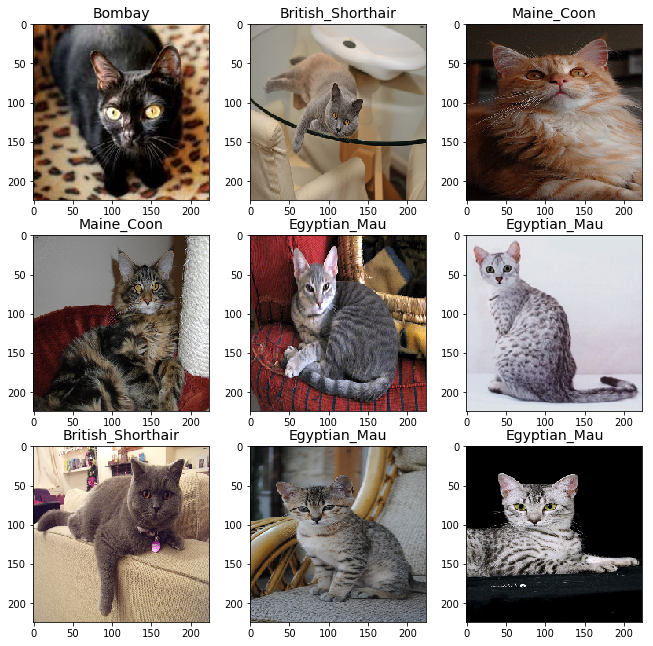

In [47]:
# show batch 
fig = plt.figure(figsize=(11,11))
gs = gridspec.GridSpec(3, 3, hspace=0.2, wspace=0.2)

for i in range(9):
    # need to change img dtype float32 to uint8 to show properly and not inverted colors
    img, label = x_batch[i].astype(np.uint8), np.argmax(y_batch[i])
    ax = plt.subplot(gs[i])
    ax.imshow(img)
    ax.set_title(inv_map[label], fontsize=14)
plt.show()

### Train model

In [48]:
# create the base pre-trained model
#base_model = ResNet50(weights='imagenet', include_top=False)

# this one has below layers
base_model = resnet.ResNet34(input_shape=x_batch.shape[1:], classes=37)

# add a global spatial average pooling layer
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # and a logistic layer -- let's say we have 37 classes
# predictions = Dense(37, activation='softmax')(x)

# this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers[:-2]:
    layer.trainable = False

reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [49]:
# create the base pre-trained model
resnet50_model = ResNet50(weights='imagenet', include_top=False)

In [50]:
resnet50_model.summary(line_length=115)

___________________________________________________________________________________________________________________
Layer (type)                         Output Shape              Param #       Connected to                          
input_4 (InputLayer)                 (None, None, None, 3)     0                                                   
___________________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)            (None, None, None, 3)     0             input_4[0][0]                         
___________________________________________________________________________________________________________________
conv1 (Conv2D)                       (None, None, None, 64)    9472          conv1_pad[0][0]                       
___________________________________________________________________________________________________________________
bn_conv1 (BatchNormalization)        (None, None, None, 64)    256      

In [51]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 112, 112, 64) 256         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_83 (Activation)      (None, 112, 112, 64) 0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
max_poolin

In [28]:
# base_model.layers[-3].output_shape

In [29]:
# resnet50_model.layers[-1].output_shape

In [30]:
# base_model.layers[-1].get_weights()

In [31]:
# resnet50_model.layers[-1].get_weights()

In [53]:
base_model.compile(optimizer=adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [54]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = base_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10
92/92 [==============================] - 20s 223ms/step - loss: 5.1652 - acc: 0.0353 - val_loss: 17.8330 - val_acc: 0.0000e+00
Epoch 2/10
92/92 [==============================] - 18s 199ms/step - loss: 5.0913 - acc: 0.0506 - val_loss: 17.8330 - val_acc: 0.0000e+00
Epoch 3/10
92/92 [==============================] - 18s 201ms/step - loss: 5.0612 - acc: 0.0643 - val_loss: 17.8330 - val_acc: 0.0000e+00
Epoch 4/10
92/92 [==============================] - 17s 189ms/step - loss: 5.0336 - acc: 0.0703 - val_loss: 17.8330 - val_acc: 0.0000e+00
Epoch 5/10
92/92 [==============================] - 18s 195ms/step - loss: 5.0193 - acc: 0.0770 - val_loss: 17.8330 - val_acc: 0.0000e+00
Epoch 6/10
92/92 [==============================] - 18s 190ms/step - loss: 4.9915 - acc: 0.0797 - val_loss: 17.8330 - val_acc: 0.0000e+00
Epoch 7/10
92/92 [==============================] - 18s 192ms/step - loss: 4.9789 - acc: 0.0850 - val_loss: 17.8330 - val_acc: 0.0000e+00
Epoch 8/10
92/92 [================

In [30]:
STEP_SIZE_TRAIN

92

In [31]:
STEP_SIZE_VALID

23

In [55]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_3
1 conv2d_37
2 batch_normalization_38
3 activation_83
4 max_pooling2d_3
5 res0a_branch2a
6 batch_normalization_39
7 conv2d_39
8 activation_84
9 batch_normalization_40
10 conv2d_38
11 add_33
12 batch_normalization_41
13 activation_85
14 conv2d_40
15 batch_normalization_42
16 activation_86
17 conv2d_41
18 add_34
19 batch_normalization_43
20 activation_87
21 conv2d_42
22 batch_normalization_44
23 activation_88
24 conv2d_43
25 add_35
26 batch_normalization_45
27 activation_89
28 conv2d_44
29 batch_normalization_46
30 conv2d_46
31 activation_90
32 batch_normalization_47
33 conv2d_45
34 add_36
35 batch_normalization_48
36 activation_91
37 conv2d_47
38 batch_normalization_49
39 activation_92
40 conv2d_48
41 add_37
42 batch_normalization_50
43 activation_93
44 conv2d_49
45 batch_normalization_51
46 activation_94
47 conv2d_50
48 add_38
49 batch_normalization_52
50 activation_95
51 conv2d_51
52 batch_normalization_53
53 activation_96
54 conv2d_52
55 add_39
56 batch_normalization_54
57 a

In [56]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in base_model.layers[:101]:
    layer.trainable = False
for layer in base_model.layers[101:]:
    layer.trainable = True

In [59]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
base_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

# we train our model again (this time fine-tuning the top blocks
# alongside the top Dense layers
history_2 = base_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

Epoch 1/30
92/92 [==============================] - 24s 262ms/step - loss: 4.8773 - acc: 0.1312 - val_loss: 17.8329 - val_acc: 0.0000e+00
Epoch 2/30
92/92 [==============================] - 19s 202ms/step - loss: 4.8780 - acc: 0.1244 - val_loss: 17.8329 - val_acc: 0.0000e+00
Epoch 3/30
92/92 [==============================] - 19s 203ms/step - loss: 4.8751 - acc: 0.1329 - val_loss: 17.8329 - val_acc: 0.0000e+00
Epoch 4/30
92/92 [==============================] - 19s 202ms/step - loss: 4.8602 - acc: 0.1325 - val_loss: 17.8328 - val_acc: 0.0000e+00
Epoch 5/30
92/92 [==============================] - 19s 204ms/step - loss: 4.8657 - acc: 0.1299 - val_loss: 17.8328 - val_acc: 0.0000e+00
Epoch 6/30
92/92 [==============================] - 19s 203ms/step - loss: 4.8613 - acc: 0.1287 - val_loss: 17.8328 - val_acc: 0.0000e+00
Epoch 7/30
92/92 [==============================] - 19s 203ms/step - loss: 4.8491 - acc: 0.1405 - val_loss: 17.8328 - val_acc: 0.0000e+00
Epoch 8/30
92/92 [================